In [296]:
using Plots
using QuadGK
using NLopt
#using SpecialFunctions
using NLsolve
using Statistics
include("../../scaling_CGS.jl")

print_all_CGS (generic function with 2 methods)

In [304]:
#---------- Double current sheet setup ----------
base = BaseUnits("CGS")

electron_mass_scaling = 1e0#4.590381684400168
charge_scaling = 1e0
eps_0_scaling = 1e0#1e2
mu_0_scaling = 1e0

scale_base_units(base, eps_0_scaling, mu_0_scaling, electron_mass_scaling, charge_scaling)

mass_density_scale = 1.6735328363560001e-15
length_scale       = 720.0847332647692 # proton skin depth
time_scale         = 3.5219920728365707e-9
temperature_scale  = 1e6


len = 720.0847332647692
number_density=1e9 
B_flux = 10
temperature   = 1e6
temperature_e = temperature
temperature_p = temperature



scaling = ScalingCGS(base,
                number_density, len, temperature, temperature_e, temperature_p, B_flux,
                length_scale, mass_density_scale, time_scale, temperature_scale)

ds = 0.001953125
per_cell = 32

set_macro_particle_weights(scaling, ds, per_cell);
print_all_CGS(scaling)



 Maxwell Lorents Factors used in code:
 k_E =                                             =  1.0000e+00 
 k_B =                                             =  6.8198e+00 
 k_F =                                             =  6.8198e+00 
 k_D =                                             =  1.0000e+00 
 k_M =                                             =  1.4663e-01 
 k_H =                                             =  1.0000e+00 

 Macro particle weights:
                          ds =                     =  1.9531e-03 
                    per_cell =                     =  3.2000e+01 
               weight_scaled =                     =  8.6934e+07 
 weight_scaled_mass_electron =                     =  1.2673e-13 
   weight_scaled_mass_proton =                     =  2.3270e-10 
        weight_scaled_charge =                     =  9.6281e-12 
                 rho_n_ratio =                     =  3.7338e+17 

 Fundamental physical constants:
        Gravitational Constant [ cm^3 g^-1

In [305]:
gamma = 1.4

scaling.mass_density_code * scaling.rho_n_ratio * scaling.k_B_code * scaling.temperature_code / (gamma - 1.0)

4.933992031514953e-9

In [42]:
function dist_to_boundary(mhd_boundary_dir, li, ui, x, y, z)

    min_dist = 1e10

    #println("test = (x,y,z) = ", x, ", ", y, ", ", z)

    for ix = -1:1
        for iy = -1:1
            for iz = -1:1
                if mhd_boundary_dir[ix,iy,iz]


                    #-------- check x ----------
                    if ix < 0 
                        _x = li[1]
                    elseif ix > 0
                        _x = ui[1]
                    else
                        _x = x
                    end
                    #----------------------------

                    #-------- check y ----------
                    if iy < 0 
                        _y = li[2]
                    elseif iy > 0
                        _y = ui[2]
                    else
                        _y = y
                    end
                    #----------------------------

                    #-------- check z ----------
                    if iz < 0 
                        _z = li[3]
                    elseif iz > 0
                        _z = ui[3]
                    else
                        _z = z
                    end
                    #----------------------------


                    dist = sqrt((_x - x)^2 + (_y - y)^2 + (_z - z)^2)

                    if dist < min_dist
                        min_dist = dist
                    end
                    
                end
            end 
        end 
    end 


    return min_dist
end

dist_to_boundary (generic function with 1 method)

In [170]:
function wave_killing(q::Float64, q0::Float64, tau::Float64, max_dist::Float64, dist ::Float64) 
    if dist <= max_dist 
        quadfunc = (1.0 - dist / max_dist)^2
        rate = -(q - q0) * quadfunc / tau
    else
        rate = 0.0
    end
    return rate
end

wave_killing (generic function with 2 methods)

In [193]:
using Statistics

function smooth_array_3d_gaussian(arr, sigma)
    # Constants for Gaussian calculation
    gaussian_constant = 1.0 / (sigma * sqrt(2.0 * π))
    window_size = Int(3.0 * sigma)  # Typically 3 sigma covers over 99% of the Gaussian distribution
    
    # Prepare the smoothed array
    smoothed_arr = copy(arr)  # Initialize with the original array

    # Iterate through the array
    for k in 1:size(arr, 3)
        for j in 1:size(arr, 2)
            for i in 1:size(arr, 1)
                sum = 0.0
                total_weight = 0.0

                # Apply the Gaussian smoothing
                for dk = -window_size:window_size
                    for dj = -window_size:window_size
                        for di = -window_size:window_size
                            # Check boundaries
                            if 1 ≤ i+di ≤ size(arr, 1) && 1 ≤ j+dj ≤ size(arr, 2) && 1 ≤ k+dk ≤ size(arr, 3)
                                x = di^2
                                y = dj^2
                                z = dk^2
                                weight = gaussian_constant * exp(-(x + y + z) / (2.0 * sigma^2))
                                sum += arr[i+di, j+dj, k+dk] * weight
                                total_weight += weight
                            end
                        end
                    end
                end

                # Normalize if total weight is significant
                if total_weight > 0.0
                    smoothed_arr[i, j, k] = sum / total_weight
                else
                    smoothed_arr[i, j, k] = arr[i, j, k]  # Use original if no weights applied
                end
            end
        end
    end

    return smoothed_arr
end


smooth_array_3d_gaussian (generic function with 1 method)

In [253]:
function mean_boundary_val(mhd_boundary_dir, arr, li, ui, lb, ub)

    mean_val = 0.0
    count = 0

    b_lb = zeros(Int,3)
    b_ub = zeros(Int,3)



    for ix = -1:1
        for iy = -1:1
            for iz = -1:1
                if mhd_boundary_dir[ix,iy,iz]


                    #-------- check x ----------
                    if ix < 0 
                        b_lb[1] = lb[1]
                        b_ub[1] = li[1] - 1
                    elseif ix > 0
                        b_lb[1] = ui[1] + 1
                        b_ub[1] = ub[1] 
                    else
                        b_lb[1] = li[1]
                        b_ub[1] = ui[1]
                    end
                    #----------------------------

                    #-------- check x ----------
                    if iy < 0 
                        b_lb[2] = lb[2]
                        b_ub[2] = li[2] - 1
                    elseif iy > 0
                        b_lb[2] = ui[2] + 1
                        b_ub[2] = ub[2] 
                    else
                        b_lb[2] = li[2]
                        b_ub[2] = ui[2]
                    end
                    #----------------------------

                    #-------- check x ----------
                    if iz < 0 
                        b_lb[3] = lb[3]
                        b_ub[3] = li[3] - 1
                    elseif iz > 0
                        b_lb[3] = ui[3] + 1
                        b_ub[3] = ub[3] 
                    else
                        b_lb[3] = li[3]
                        b_ub[3] = ui[3]
                    end
                    #----------------------------




                    mean_val += sum(arr[b_lb[1]:b_ub[1], b_lb[2]:b_ub[2]])

                    count += prod(b_ub .- b_lb .+ 1)

                end
            end 
        end 
    end 

    mean_val = mean_val / count

    return mean_val, count 
end

mean_boundary_val (generic function with 2 methods)

In [285]:
function mean_boundary_val(mhd_boundary_dir, arr, li, ui, lb, ub)
    mean_val = 0.0
    count = 0

    # Loop over all possible directions
    for ix = -1:1
        for iy = -1:1
            for iz = -1:1
                if mhd_boundary_dir[ix,iy,iz]
                    direction = [ix,iy,iz]

                    b_lb = [direction[d] < 0 ? lb[d] : direction[d] > 0 ? ui[d] + 1 : li[d] for d in 1:3]
                    b_ub = [direction[d] < 0 ? li[d] - 1 : direction[d] > 0 ? ub[d] : ui[d] for d in 1:3]

                    region = arr[b_lb[1]:b_ub[1], b_lb[2]:b_ub[2]]#, b_lb[3]:b_ub[3]]
                    mean_val += sum(region)
                    count += length(region)
                end
            end
        end
    end

    mean_val = count > 0 ? mean_val / count : 0.0
    return mean_val, count
end


mean_boundary_val (generic function with 2 methods)

In [286]:
mean_boundary_val(mhd_boundary_dir, test_arr[:,:,1],li, ui, lb, ub)

(1.012630912804074, 123)

In [290]:
using OffsetArrays

# Create a 3x3x3 Boolean array with indices from -1 to 1
mhd_boundary_dir = OffsetArray(falses(3, 3, 3), -1:1, -1:1, -1:1)

# Setting values to true as an example
mhd_boundary_dir[-1, -1, 0] = true  # Example setting
mhd_boundary_dir[0, -1, 0] = true  # Example setting
mhd_boundary_dir[1, -1, 0] = true  # Example setting


#mhd_boundary_dir[1, -1, 0] = true  # Example setting
#mhd_boundary_dir[1, 0 , 0] = true  # Example setting
#mhd_boundary_dir[1,  1, 0] = true  # Example setting



lb = [1,1,1]
ub = [22,22,7]
ng = [3,3,3]
li = lb + ng
ui = ub - ng
n = ui - li .+ 1


test_arr = rand(Float64, ub[1], ub[2],100) .+ 0.5
test_arr[li[1]:ui[1], li[2]:ui[2],1] = test_arr[li[1]:ui[1], li[2]:ui[2],1] .+ range(1,stop=0,length=n[2])'

test_arr[lb[1]:ub[1], 1:3,1] .= 1.0


dist_arr = zeros(Float64, ub[1], ub[2])

dt = 0.1
tau = 1.0



min_dist = 0.0
max_dist = maximum(n) * 1.0


for i = 2:100
    if any(mhd_boundary_dir) 
        test_arr[:,:,i] .= test_arr[:,:,i-1]

        smooth_arr = smooth_array_3d_gaussian(test_arr[:,:,i-1], 1.0)

        mean_val, count = mean_boundary_val(mhd_boundary_dir, test_arr[:,:,i-1],li, ui, lb, ub)

        avg_val = mean(test_arr[li[1]:ui[1],li[2]:ui[2],i-1])
        for ix = li[1]:ui[1]
            for iy = li[2]:ui[2]
                #println("ix: ", ix, " iy: ", iy)
                dist = dist_to_boundary(mhd_boundary_dir, li, ui, ix, iy, 0)
                #test_arr[ix, iy,i] = test_arr[ix, iy,i-1] + dt * wave_killing(test_arr[ix, iy,i-1], 1.0, tau, max_dist, dist)
                #test_arr[ix, iy,i] = test_arr[ix, iy,i-1] + dt * wave_killing(test_arr[ix, iy,i-1], avg_val, tau, max_dist, dist)
                #test_arr[ix, iy,i] = test_arr[ix, iy,i-1] + dt * wave_killing(test_arr[ix, iy,i-1], smooth_arr[ix,iy], tau, max_dist, dist)
                test_arr[ix, iy,i] = test_arr[ix, iy,i-1] + dt * wave_killing(test_arr[ix, iy,i-1], mean_val, tau, max_dist, dist)

            end 
        end

    end 
end



In [291]:
anim = @animate for i in 1:100
    heatmap(test_arr[:,:,i]')
end


mp4(anim, fps=10)

┌ Info: Saved animation to /var/folders/1b/dvkj71vd0tg6rx46ll5xjj1w0000gp/T/jl_ExIfMdMrMh.mp4
└ @ Plots /Users/michhaa/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/var/folders/1b/dvkj71vd0tg6rx46ll5xjj1w0000gp/T/jl_ExIfMdMrMh.mp4")

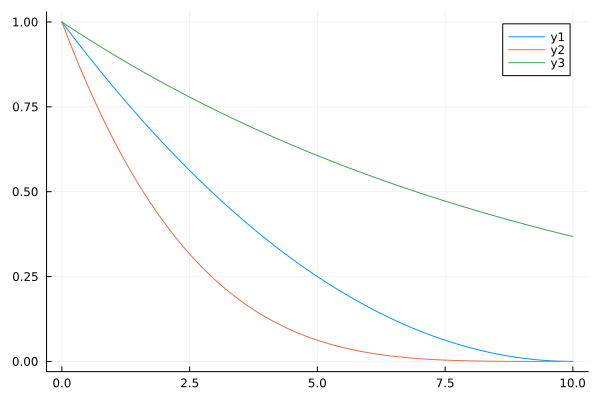

In [326]:
max_dist = 10


dist = range(0, stop=max_dist, length=1000)


quadfunc = (1.0 .- dist / max_dist).^2
quadfunc2 = (1.0 .- dist / max_dist).^4

plot(dist, quadfunc)
plot!(dist,quadfunc2)
plot!(dist,expfunc)